## Import Required Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import defaultdict
import pandas as pd


## Set Dataset Paths

In [4]:
train_dir = 'Dataset/train_set'
test_dir = 'Dataset/test_set'


## Count Images Per Class

In [6]:
def count_images_by_class(directory):
    class_counts = {}
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            class_counts[category] = len(os.listdir(category_path))
    return class_counts

train_counts = count_images_by_class(train_dir)
test_counts = count_images_by_class(test_dir)

print("Train Class Distribution:")
print(train_counts)
print("\nTest Class Distribution:")
print(test_counts)


Train Class Distribution:
{'BA- cellulitis': 136, 'BA-impetigo': 80, 'FU-athlete-foot': 124, 'FU-nail-fungus': 129, 'FU-ringworm': 90, 'PA-cutaneous-larva-migrans': 100, 'VI-chickenpox': 136, 'VI-shingles': 130}

Test Class Distribution:
{'BA- cellulitis': 34, 'BA-impetigo': 20, 'FU-athlete-foot': 32, 'FU-nail-fungus': 33, 'FU-ringworm': 23, 'PA-cutaneous-larva-migrans': 25, 'VI-chickenpox': 34, 'VI-shingles': 33}


## Plot Image Counts

<Figure size 1200x600 with 0 Axes>

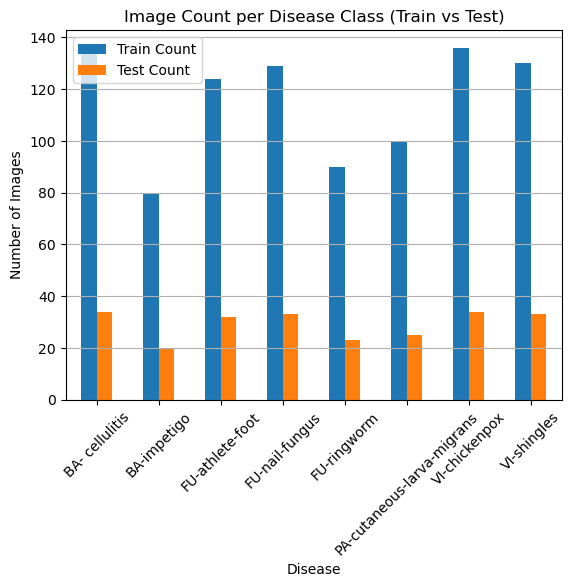

In [8]:
# Convert to DataFrame for plotting
train_df = pd.DataFrame(list(train_counts.items()), columns=["Disease", "Train Count"])
test_df = pd.DataFrame(list(test_counts.items()), columns=["Disease", "Test Count"])

# Merge for total distribution
merged_df = train_df.merge(test_df, on="Disease")

# Plot
plt.figure(figsize=(12,6))
merged_df.set_index("Disease").plot(kind="bar")
plt.title("Image Count per Disease Class (Train vs Test)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## Display Sample Images from Each Class

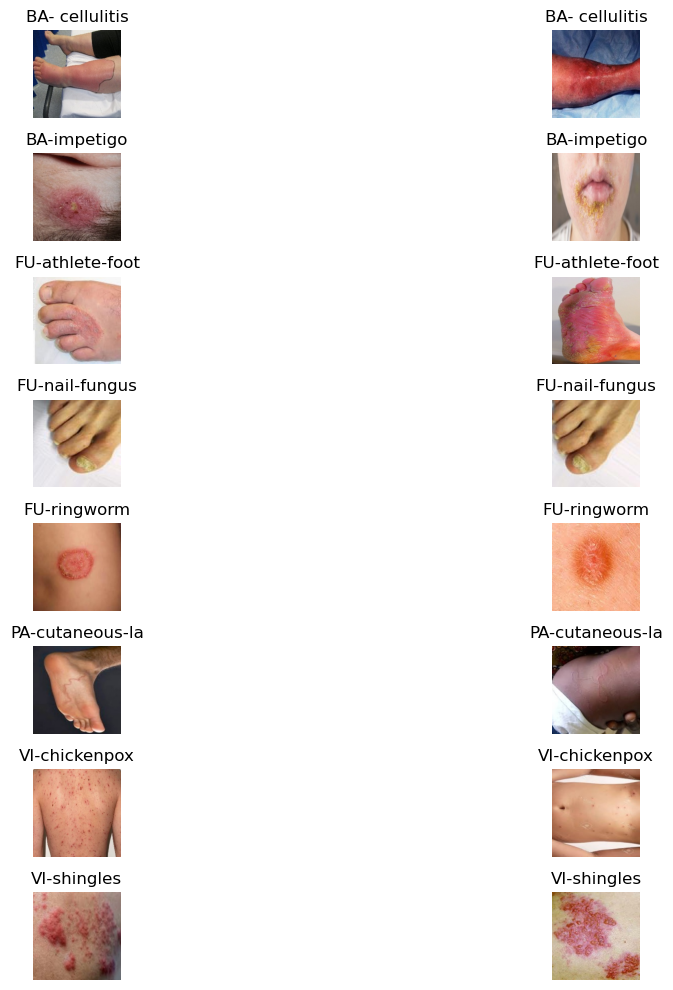

In [10]:
def show_sample_images(directory, n=2):
    categories = os.listdir(directory)
    plt.figure(figsize=(15, 10))

    for i, category in enumerate(categories):
        folder = os.path.join(directory, category)
        images = os.listdir(folder)
        for j in range(n):
            img_path = os.path.join(folder, images[j])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(categories), n, i * n + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(category[:15])

    plt.tight_layout()
    plt.show()

show_sample_images(train_dir, n=2)


##  Image Dimension Check

In [12]:
img_shapes = []

for category in os.listdir(train_dir):
    path = os.path.join(train_dir, category)
    first_img = os.path.join(path, os.listdir(path)[0])
    img = cv2.imread(first_img)
    img_shapes.append(img.shape)

# Print unique dimensions
unique_shapes = set(img_shapes)
print("Unique image dimensions in training set:", unique_shapes)


Unique image dimensions in training set: {(198, 198, 3), (250, 250, 3), (227, 227, 3), (128, 128, 3), (224, 224, 3), (205, 205, 3)}


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


##  Setup Image Generators for Train/Test

In [29]:
# train_dir = 'dataset/train'
# test_dir = 'dataset/test
IMG_SIZE = (128, 128)  # target image size

# Rescaling and augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,        # normalize pixels to [0, 1]
    rotation_range=15,     # slight rotation
    zoom_range=0.1,        
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2   # split 20% of train into validation
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation images
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 741 images belonging to 8 classes.
Found 183 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


#  Build & Train CNN Model

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [34]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\shera\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,672 (12.61 MB)

 Trainable params: 3,305,672 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [37]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


C:\Users\shera\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.1083 - loss: 2.1370 - val_accuracy: 0.1475 - val_loss: 2.0287
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1762 - loss: 2.0165 - val_accuracy: 0.2295 - val_loss: 1.9103
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2450 - loss: 1.9411 - val_accuracy: 0.3279 - val_loss: 1.8239
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 973ms/step - accuracy: 0.2989 - loss: 1.9016 - val_accuracy: 0.4262 - val_loss: 1.6371
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 932ms/step - accuracy: 0.3469 - loss: 1.7555 - val_accuracy: 0.3661 - val_loss: 1.7896
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 951ms/step - accuracy: 0.3540 - loss: 1.7523 - val_accuracy: 0.4317 - val_loss: 1.5470
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 951ms/step - accuracy: 0.3834 - loss: 1.6087 - val_accuracy: 0.5137 - val_loss: 1.4863
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4066 - loss: 1.5970 - val_accuracy: 0.4590

## Visualize Accuracy & Loss

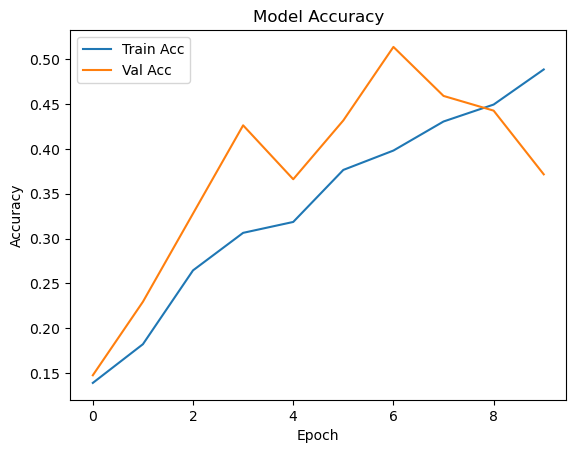

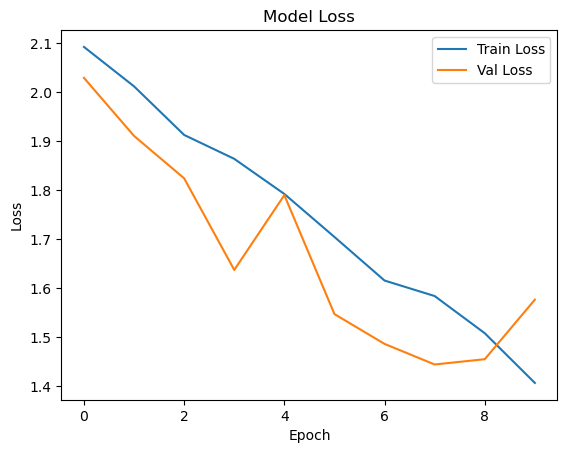

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## MORE ACCURACY

In [45]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [47]:
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base model


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 16s 2us/step


In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [51]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [53]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30
)


Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3192 - loss: 2.1296 - val_accuracy: 0.7923 - val_loss: 0.7914
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 801ms/step - accuracy: 0.6998 - loss: 0.8872 - val_accuracy: 0.8361 - val_loss: 0.5627
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 737ms/step - accuracy: 0.7811 - loss: 0.6002 - val_accuracy: 0.8579 - val_loss: 0.4249
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 708ms/step - accuracy: 0.8321 - loss: 0.5394 - val_accuracy: 0.8634 - val_loss: 0.4117
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 678ms/step - accuracy: 0.8698 - loss: 0.4184 - val_accuracy: 0.8251 - val_loss: 0.4182
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 717ms/step - accuracy: 0.8946 - loss: 0.3290 - val_accuracy: 0.9016 - val_loss: 0.3059
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 704ms/step - accuracy: 0.9109 - loss: 0.2845 - val_accuracy: 0.9071 - val_loss: 0.3068
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 716ms/step - accuracy: 0.9243 - loss: 0.2426 - val_accurac

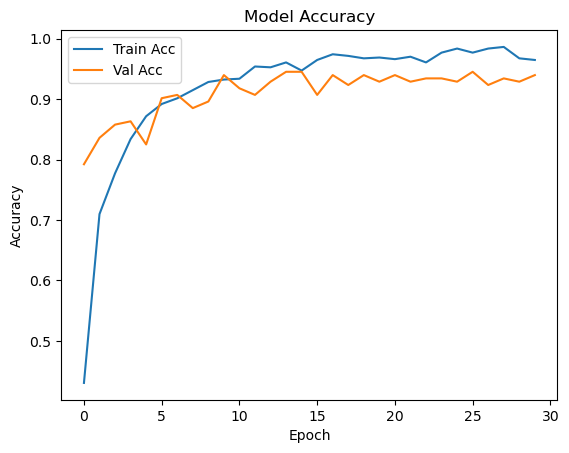

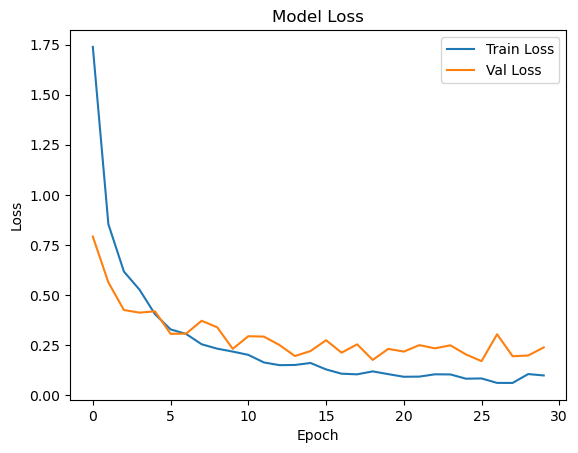

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [59]:
test_loss, test_acc = model.evaluate(test_data)
print("📊 Test Accuracy:", round(test_acc * 100, 2), "%")


C:\Users\shera\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 613ms/step - accuracy: 0.9317 - loss: 0.2562
📊 Test Accuracy: 91.85 %


In [61]:
model.save("ml_model/skin_disease_mobilenet.h5")


In [63]:
# Save in both formats if unsure
model.save("ml_model/skin_disease_model.keras")
